<a href="https://colab.research.google.com/github/kathleenreily/LifeExpectancyModel/blob/master/LifeExpectancyModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.datasets import load_iris
# from matplotlib.mlab import PCA as mlabPCA # deprecated
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpect_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# close the connection 
engine.dispose()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
lifeexpect_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [3]:
lifeexpect_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
lifeexpect_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on my analysis and select an appropriate method to deal with them.

In [5]:
lifeexpect_df.isnull().sum()/lifeexpect_df.isnull().count() #calculating percentage of missing values in each column

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.066031
percentage expenditure             0.000000
Hepatitis B                        0.188223
Measles                            0.000000
 BMI                               0.011572
under-five deaths                  0.000000
Polio                              0.006467
Total expenditure                  0.076923
Diphtheria                         0.006467
 HIV/AIDS                          0.000000
GDP                                0.152485
Population                         0.221920
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

In [0]:
#because this is a time series I will use interpolation to first handle the null values even though there are few
#first make a fill list

fill_list = [' BMI ',
    ' thinness  1-19 years',
    ' thinness 5-9 years',
    'Adult Mortality',
    'Alcohol',
    'Diphtheria ',
    'GDP',
    'Hepatitis B',
    'Income composition of resources',
    'Life expectancy ',
    'Polio',
    'Population',
    'Schooling',
    'Total expenditure',
    'under-five deaths ']

#lifeexpect_df = DataFrame(fill_list,columns=['Column_Name'])
years = lifeexpect_df["Year"].unique() #we need to take an id/identifier so we can use a unique list to fill the nulls

for year in years:
    lifeexpect_df.loc[lifeexpect_df["Year"] == year, fill_list] = lifeexpect_df.loc[lifeexpect_df["Year"] == year, fill_list].interpolate()

# we drop the null values after interpolation
lifeexpect_df.dropna(inplace=True)

In [7]:
lifeexpect_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


My goal in this challenge is to find the factors that affect the life expectancy. Specifically, I need to find out which factors increase the expected life in the countries and which factors decrease it. Therefore my target is life expectancy let's find the features with the highest amount of explanatory power. 

Index(['Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


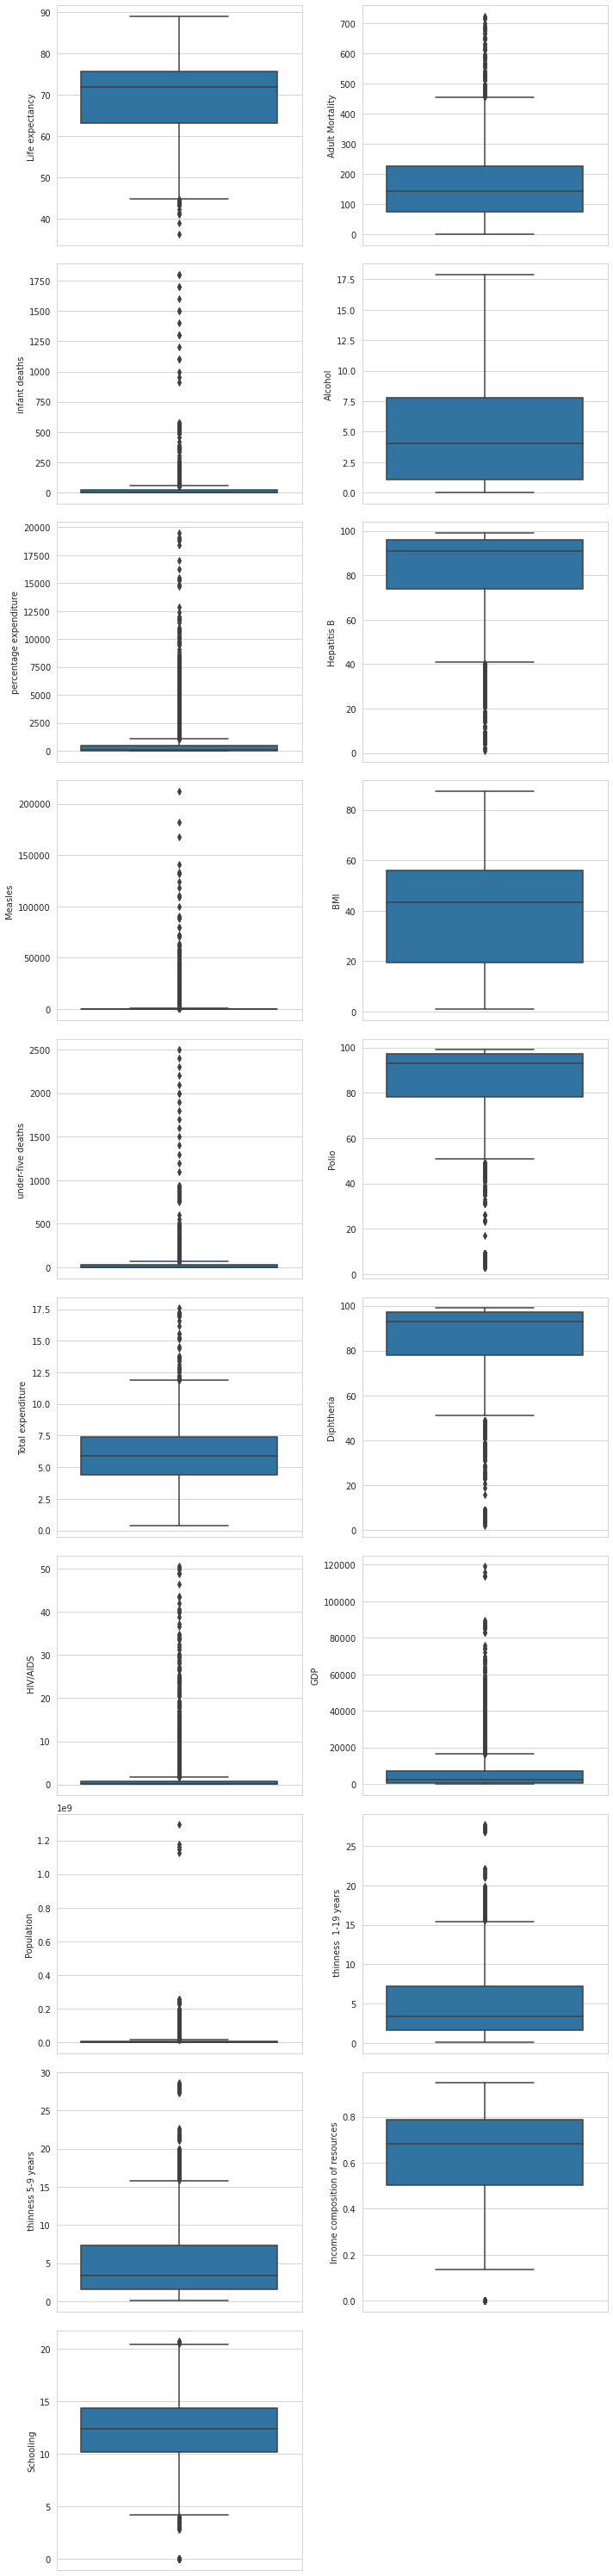

In [8]:
#we can use a simpler for loop than above to run outlier detection on all the variables

cl = lifeexpect_df.columns
cl= cl[3:24]

plt.figure(figsize = (10,50)) 
print(cl)
for i, column in enumerate(lifeexpect_df[cl]): 
  plt.subplot(12, 2, i + 1) 
  sns.boxplot(x=column, data=lifeexpect_df[cl], orient = 'v')

plt.tight_layout() #this function removes overflow/overlap of the graphs

In [0]:
#now we need to measure the amount of outliers, and then minimize their effect likely through 
#winsorization (i need to do winsorization for those that need upper, none at all, just lower, and both)

In [10]:
#let's use Tukey's method to measure how many outliers are in those particular columns that have them. 
#life-expectancy: we can see at a threshold of 1 there are 148 outliers, at a threshold of 1.5 there are 17, and beyond that 0
q75, q25 = np.percentile(lifeexpect_df["Life expectancy "], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Life expectancy "] > max_val) 
                      | (lifeexpect_df["Life expectancy "] < min_val))[0]))
    ))


The score threshold is: 1.0
Number of outliers is: 148
The score threshold is: 1.5
Number of outliers is: 17
The score threshold is: 2.0
Number of outliers is: 1
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [11]:
#adult mortality: at threshold 1 we see 183, 1.5 we see 86 and so forth, there are significantly more in adult mortality than above

q75, q25 = np.percentile(lifeexpect_df['Adult Mortality'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df['Adult Mortality'] > max_val) 
                      | (lifeexpect_df['Adult Mortality'] < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 183
The score threshold is: 1.5
Number of outliers is: 86
The score threshold is: 2.0
Number of outliers is: 41
The score threshold is: 2.5
Number of outliers is: 22
The score threshold is: 3.0
Number of outliers is: 5
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [12]:
#infant deaths: has a large amount of outliers starting with 419

q75, q25 = np.percentile(lifeexpect_df["infant deaths"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["infant deaths"] > max_val) 
                      | (lifeexpect_df["infant deaths"] < min_val))[0]))
    ))


The score threshold is: 1.0
Number of outliers is: 419
The score threshold is: 1.5
Number of outliers is: 315
The score threshold is: 2.0
Number of outliers is: 226
The score threshold is: 2.5
Number of outliers is: 187
The score threshold is: 3.0
Number of outliers is: 158
The score threshold is: 3.5
Number of outliers is: 138
The score threshold is: 4.0
Number of outliers is: 130
The score threshold is: 4.5
Number of outliers is: 121


In [13]:
#percentage expenditure: similar to infant deaths we have alot of outliers, starting at 454

q75, q25 = np.percentile(lifeexpect_df["percentage expenditure"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["percentage expenditure"] > max_val) 
                      | (lifeexpect_df["percentage expenditure"] < min_val))[0]))
    ))


The score threshold is: 1.0
Number of outliers is: 454
The score threshold is: 1.5
Number of outliers is: 389
The score threshold is: 2.0
Number of outliers is: 349
The score threshold is: 2.5
Number of outliers is: 323
The score threshold is: 3.0
Number of outliers is: 300
The score threshold is: 3.5
Number of outliers is: 279
The score threshold is: 4.0
Number of outliers is: 258
The score threshold is: 4.5
Number of outliers is: 241


In [14]:
#hepatitus b: not so many starting at 373

q75, q25 = np.percentile(lifeexpect_df["Hepatitis B"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Hepatitis B"] > max_val) 
                      | (lifeexpect_df["Hepatitis B"] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 373
The score threshold is: 1.5
Number of outliers is: 281
The score threshold is: 2.0
Number of outliers is: 227
The score threshold is: 2.5
Number of outliers is: 194
The score threshold is: 3.0
Number of outliers is: 62
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [15]:
#measles: this variable has a ton of outliers starting at 593

q75, q25 = np.percentile(lifeexpect_df["Measles "], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Measles "] > max_val) 
                      | (lifeexpect_df["Measles "] < min_val))[0]))
    ))


 

The score threshold is: 1.0
Number of outliers is: 593
The score threshold is: 1.5
Number of outliers is: 542
The score threshold is: 2.0
Number of outliers is: 513
The score threshold is: 2.5
Number of outliers is: 480
The score threshold is: 3.0
Number of outliers is: 451
The score threshold is: 3.5
Number of outliers is: 423
The score threshold is: 4.0
Number of outliers is: 409
The score threshold is: 4.5
Number of outliers is: 396


In [16]:
#under 5 deaths: many starting at 465

q75, q25 = np.percentile(lifeexpect_df["under-five deaths "], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["under-five deaths "] > max_val) 
                      | (lifeexpect_df["under-five deaths "] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 465
The score threshold is: 1.5
Number of outliers is: 394
The score threshold is: 2.0
Number of outliers is: 308
The score threshold is: 2.5
Number of outliers is: 232
The score threshold is: 3.0
Number of outliers is: 195
The score threshold is: 3.5
Number of outliers is: 163
The score threshold is: 4.0
Number of outliers is: 145
The score threshold is: 4.5
Number of outliers is: 133


In [17]:
#polio: starting at 359

q75, q25 = np.percentile(lifeexpect_df["Polio"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Polio"] > max_val) 
                      | (lifeexpect_df["Polio"] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 359
The score threshold is: 1.5
Number of outliers is: 279
The score threshold is: 2.0
Number of outliers is: 202
The score threshold is: 2.5
Number of outliers is: 179
The score threshold is: 3.0
Number of outliers is: 173
The score threshold is: 3.5
Number of outliers is: 172
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [18]:
#total expenditure

q75, q25 = np.percentile(lifeexpect_df["Total expenditure"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Total expenditure"] > max_val) 
                      | (lifeexpect_df["Total expenditure"] < min_val))[0]))
    ))

             

The score threshold is: 1.0
Number of outliers is: 148
The score threshold is: 1.5
Number of outliers is: 42
The score threshold is: 2.0
Number of outliers is: 25
The score threshold is: 2.5
Number of outliers is: 14
The score threshold is: 3.0
Number of outliers is: 8
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [19]:
#diptheria

q75, q25 = np.percentile(lifeexpect_df["Diphtheria "], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Diphtheria "] > max_val) 
                      | (lifeexpect_df["Diphtheria "] < min_val))[0]))
    ))

         

The score threshold is: 1.0
Number of outliers is: 349
The score threshold is: 1.5
Number of outliers is: 299
The score threshold is: 2.0
Number of outliers is: 230
The score threshold is: 2.5
Number of outliers is: 191
The score threshold is: 3.0
Number of outliers is: 172
The score threshold is: 3.5
Number of outliers is: 170
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [20]:
#HIV/AIDS: 

q75, q25 = np.percentile(lifeexpect_df[" HIV/AIDS"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df[" HIV/AIDS"] > max_val) 
                      | (lifeexpect_df[" HIV/AIDS"] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 584
The score threshold is: 1.5
Number of outliers is: 542
The score threshold is: 2.0
Number of outliers is: 474
The score threshold is: 2.5
Number of outliers is: 435
The score threshold is: 3.0
Number of outliers is: 403
The score threshold is: 3.5
Number of outliers is: 373
The score threshold is: 4.0
Number of outliers is: 347
The score threshold is: 4.5
Number of outliers is: 325


In [21]:
#GDP

q75, q25 = np.percentile(lifeexpect_df["GDP"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["GDP"] > max_val) 
                      | (lifeexpect_df["GDP"] < min_val))[0]))
    ))

    

The score threshold is: 1.0
Number of outliers is: 495
The score threshold is: 1.5
Number of outliers is: 419
The score threshold is: 2.0
Number of outliers is: 377
The score threshold is: 2.5
Number of outliers is: 335
The score threshold is: 3.0
Number of outliers is: 294
The score threshold is: 3.5
Number of outliers is: 262
The score threshold is: 4.0
Number of outliers is: 228
The score threshold is: 4.5
Number of outliers is: 195


In [22]:
#population

q75, q25 = np.percentile(lifeexpect_df["Population"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Population"] > max_val) 
                      | (lifeexpect_df["Population"] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 466
The score threshold is: 1.5
Number of outliers is: 368
The score threshold is: 2.0
Number of outliers is: 338
The score threshold is: 2.5
Number of outliers is: 295
The score threshold is: 3.0
Number of outliers is: 263
The score threshold is: 3.5
Number of outliers is: 237
The score threshold is: 4.0
Number of outliers is: 208
The score threshold is: 4.5
Number of outliers is: 191


In [23]:
#thinnes 1-19 years

q75, q25 = np.percentile(lifeexpect_df[" thinness  1-19 years"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df[" thinness  1-19 years"] > max_val) 
                      | (lifeexpect_df[" thinness  1-19 years"] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 179
The score threshold is: 1.5
Number of outliers is: 89
The score threshold is: 2.0
Number of outliers is: 47
The score threshold is: 2.5
Number of outliers is: 21
The score threshold is: 3.0
Number of outliers is: 16
The score threshold is: 3.5
Number of outliers is: 15
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [24]:
#thinnes 5-9 years

q75, q25 = np.percentile(lifeexpect_df[" thinness 5-9 years"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df[" thinness 5-9 years"] > max_val) 
                      | (lifeexpect_df[" thinness 5-9 years"] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 179
The score threshold is: 1.5
Number of outliers is: 95
The score threshold is: 2.0
Number of outliers is: 51
The score threshold is: 2.5
Number of outliers is: 22
The score threshold is: 3.0
Number of outliers is: 16
The score threshold is: 3.5
Number of outliers is: 16
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [25]:
#income composition of resources

q75, q25 = np.percentile(lifeexpect_df["Income composition of resources"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Income composition of resources"] > max_val) 
                      | (lifeexpect_df["Income composition of resources"] < min_val))[0]))
    ))



The score threshold is: 1.0
Number of outliers is: 131
The score threshold is: 1.5
Number of outliers is: 130
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [26]:
#schooling

q75, q25 = np.percentile(lifeexpect_df["Schooling"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Schooling"] > max_val) 
                      | (lifeexpect_df["Schooling"] < min_val))[0]))
    ))


The score threshold is: 1.0
Number of outliers is: 193
The score threshold is: 1.5
Number of outliers is: 53
The score threshold is: 2.0
Number of outliers is: 28
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [27]:
#adult mortality

q75, q25 = np.percentile(lifeexpect_df["Adult Mortality"], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((lifeexpect_df["Adult Mortality"] > max_val) 
                      | (lifeexpect_df["Adult Mortality"] < min_val))[0]))
    ))


  

The score threshold is: 1.0
Number of outliers is: 183
The score threshold is: 1.5
Number of outliers is: 86
The score threshold is: 2.0
Number of outliers is: 41
The score threshold is: 2.5
Number of outliers is: 22
The score threshold is: 3.0
Number of outliers is: 5
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [0]:
#we need to now handle our outliers using the winsorization method and log method for those variables that we cannot fix with 
#winsorization

from scipy.stats.mstats import winsorize

lifeexpect_df['winsorized_expectancy'] = winsorize(lifeexpect_df["Life expectancy "], (0.05, 0))
lifeexpect_df['winsorized_adult'] = winsorize(lifeexpect_df["Adult Mortality"], (0, 0.10))
lifeexpect_df['winsorized_infant'] = winsorize(lifeexpect_df["infant deaths"], (0, 0.10))
#lifeexpect_df['winsorized_percentexp'] = winsorize(lifeexpect_df["percentage expenditure"], (0.40, 0))
lifeexpect_df['winsorized_hepatitis'] = winsorize(lifeexpect_df["Hepatitis B"], (0, 0.10))   
#lifeexpect_df['winsorized_measles'] = winsorize(lifeexpect_df["Measles "], (0.40, 0))     
#lifeexpect_df['winsorized_fivedeaths'] = winsorize(lifeexpect_df["under-five deaths "], (0.40, 0))                       
lifeexpect_df['winsorized_polio'] = winsorize(lifeexpect_df["Polio"], (0, 0.10))  
lifeexpect_df['winsorized_totalexp'] = winsorize(lifeexpect_df["Total expenditure"], (0.10, 0))                       
lifeexpect_df['winsorized_diptheria'] = winsorize(lifeexpect_df["Diphtheria "], (0, 0.10)) 

#lifeexpect_df['winsorized_hivaids'] = winsorize(lifeexpect_df[" HIV/AIDS"], (0.40, 0))
#lifeexpect_df['winsorized_gdp'] = winsorize(lifeexpect_df["GDP"], (0.40, 0))   
#lifeexpect_df['winsorized_population'] = winsorize(lifeexpect_df["Population"], (0.40, 0))     
lifeexpect_df['winsorized_thin119'] = winsorize(lifeexpect_df[" thinness  1-19 years"], (0.10, 0))                       
lifeexpect_df['winsorized_thin59'] = winsorize(lifeexpect_df[" thinness 5-9 years"], (0.10, 0))  
lifeexpect_df['winsorized_incomecomp'] = winsorize(lifeexpect_df["Income composition of resources"], (0.10, 0))                       
lifeexpect_df['winsorized_schooling'] = winsorize(lifeexpect_df["Schooling"], (0, 0.05))  

lifeexpect_df["log_percentage_expenditure"] = np.log(lifeexpect_df["percentage expenditure"])
lifeexpect_df["log_measles"] = np.log(lifeexpect_df["Measles "])
lifeexpect_df["log_under-five_deaths"] = np.log(lifeexpect_df["under-five deaths "])
lifeexpect_df["log_HIV/AIDS"] = np.log(lifeexpect_df[" HIV/AIDS"])
lifeexpect_df["log_Population"] = np.log(lifeexpect_df["Population"])
lifeexpect_df["log_GDP"] = np.log(lifeexpect_df["GDP"])


#some variables have so many outliers even when I cap them at values >10% the outliers are not going away therefore I will use
#log transformation for the following variables: percentage exp, measles, under-5 deaths, HIV/AIDS, gdp, population

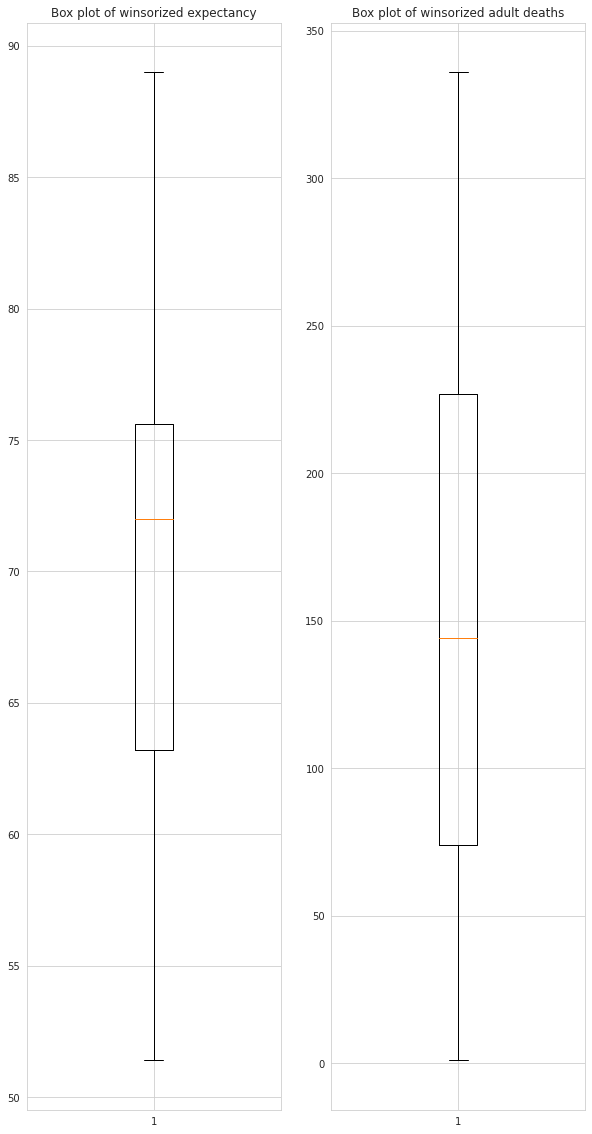

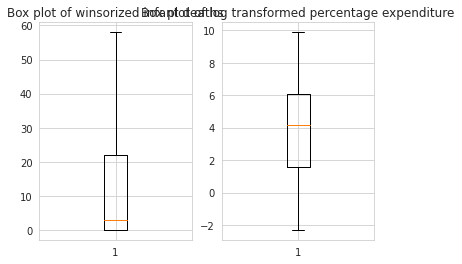

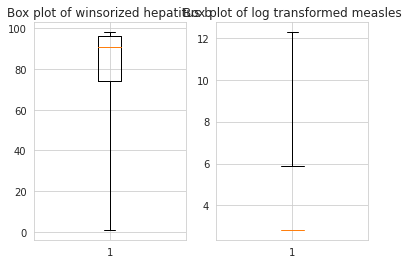

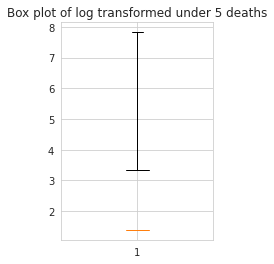

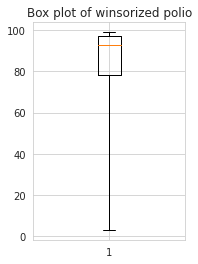

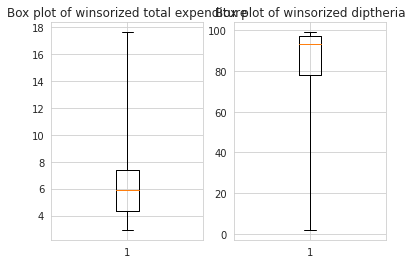

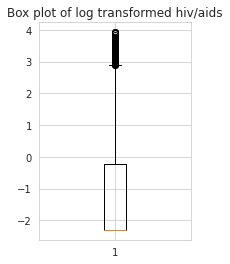

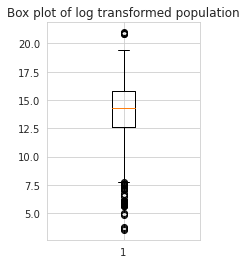

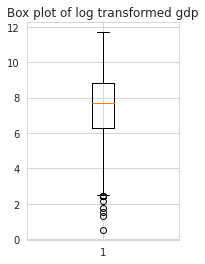

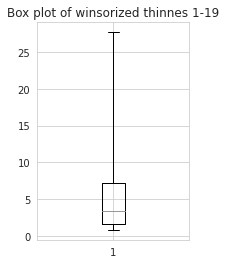

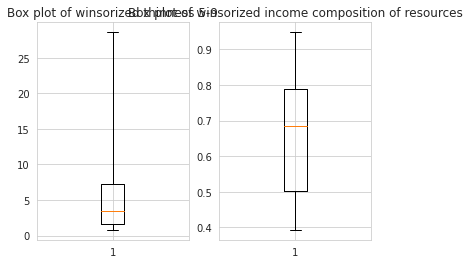

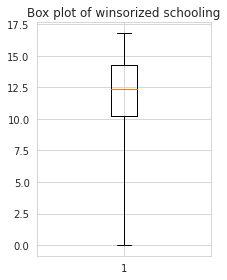

In [29]:
#we need to confirm the outliers have been dealt with, let's check with boxplots

plt.figure(figsize = (10,20))

plt.subplot(1,2,1)
plt.boxplot(lifeexpect_df['winsorized_expectancy'], whis = 5)
plt.title("Box plot of winsorized expectancy")

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df['winsorized_adult'], whis = 5)
plt.title("Box plot of winsorized adult deaths")
plt.show()

plt.subplot(1,2,1)
plt.boxplot(lifeexpect_df['winsorized_infant'], whis = 5)
plt.title("Box plot of winsorized infant deaths")

"""PERCENTAGE EXPENDITURE"""

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df["log_percentage_expenditure"])
plt.title("Box plot of log transformed percentage expenditure")
plt.show()

plt.subplot(1,2,1)
plt.boxplot(lifeexpect_df['winsorized_hepatitis'], whis = 5)
plt.title("Box plot of winsorized hepatitus b")

"""MEASLE"""

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df["log_measles"])
plt.title("Box plot of log transformed measles")
plt.show()

"""UNDER 5 DEATHS"""

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df["log_under-five_deaths"])
plt.title("Box plot of log transformed under 5 deaths")
plt.show()

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df['winsorized_polio'], whis = 5)
plt.title("Box plot of winsorized polio")
plt.show()

plt.subplot(1,2,1)
plt.boxplot(lifeexpect_df['winsorized_totalexp'], whis = 5)
plt.title("Box plot of winsorized total expenditure")

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df['winsorized_diptheria'], whis = 5)
plt.title("Box plot of winsorized diptheria")
plt.show()

"""HIV/AIDS"""

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df["log_HIV/AIDS"])
plt.title("Box plot of log transformed hiv/aids")
plt.show()

"""POPULATION"""

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df["log_Population"])
plt.title("Box plot of log transformed population")
plt.show()

"""GDP"""

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df["log_GDP"])
plt.title("Box plot of log transformed gdp")
plt.show()

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df['winsorized_thin119'], whis = 5)
plt.title("Box plot of winsorized thinnes 1-19")
plt.show()

plt.subplot(1,2,1)
plt.boxplot(lifeexpect_df['winsorized_thin59'], whis = 5)
plt.title("Box plot of winsorized thinness 5-9")

plt.subplot(1,2,2)
plt.boxplot(lifeexpect_df['winsorized_incomecomp'], whis = 5)
plt.title("Box plot of winsorized income composition of resources")
plt.show()

plt.subplot(1,2,1)
plt.boxplot(lifeexpect_df['winsorized_schooling'], whis = 5)
plt.title("Box plot of winsorized schooling")


plt.tight_layout()

#after applying the log transformation to the variables with the largest number of outliers because winsorization did not help
#all but three have been fixed, gdp, hiv/aids, and population still have a few outliers, but this will do for now

Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

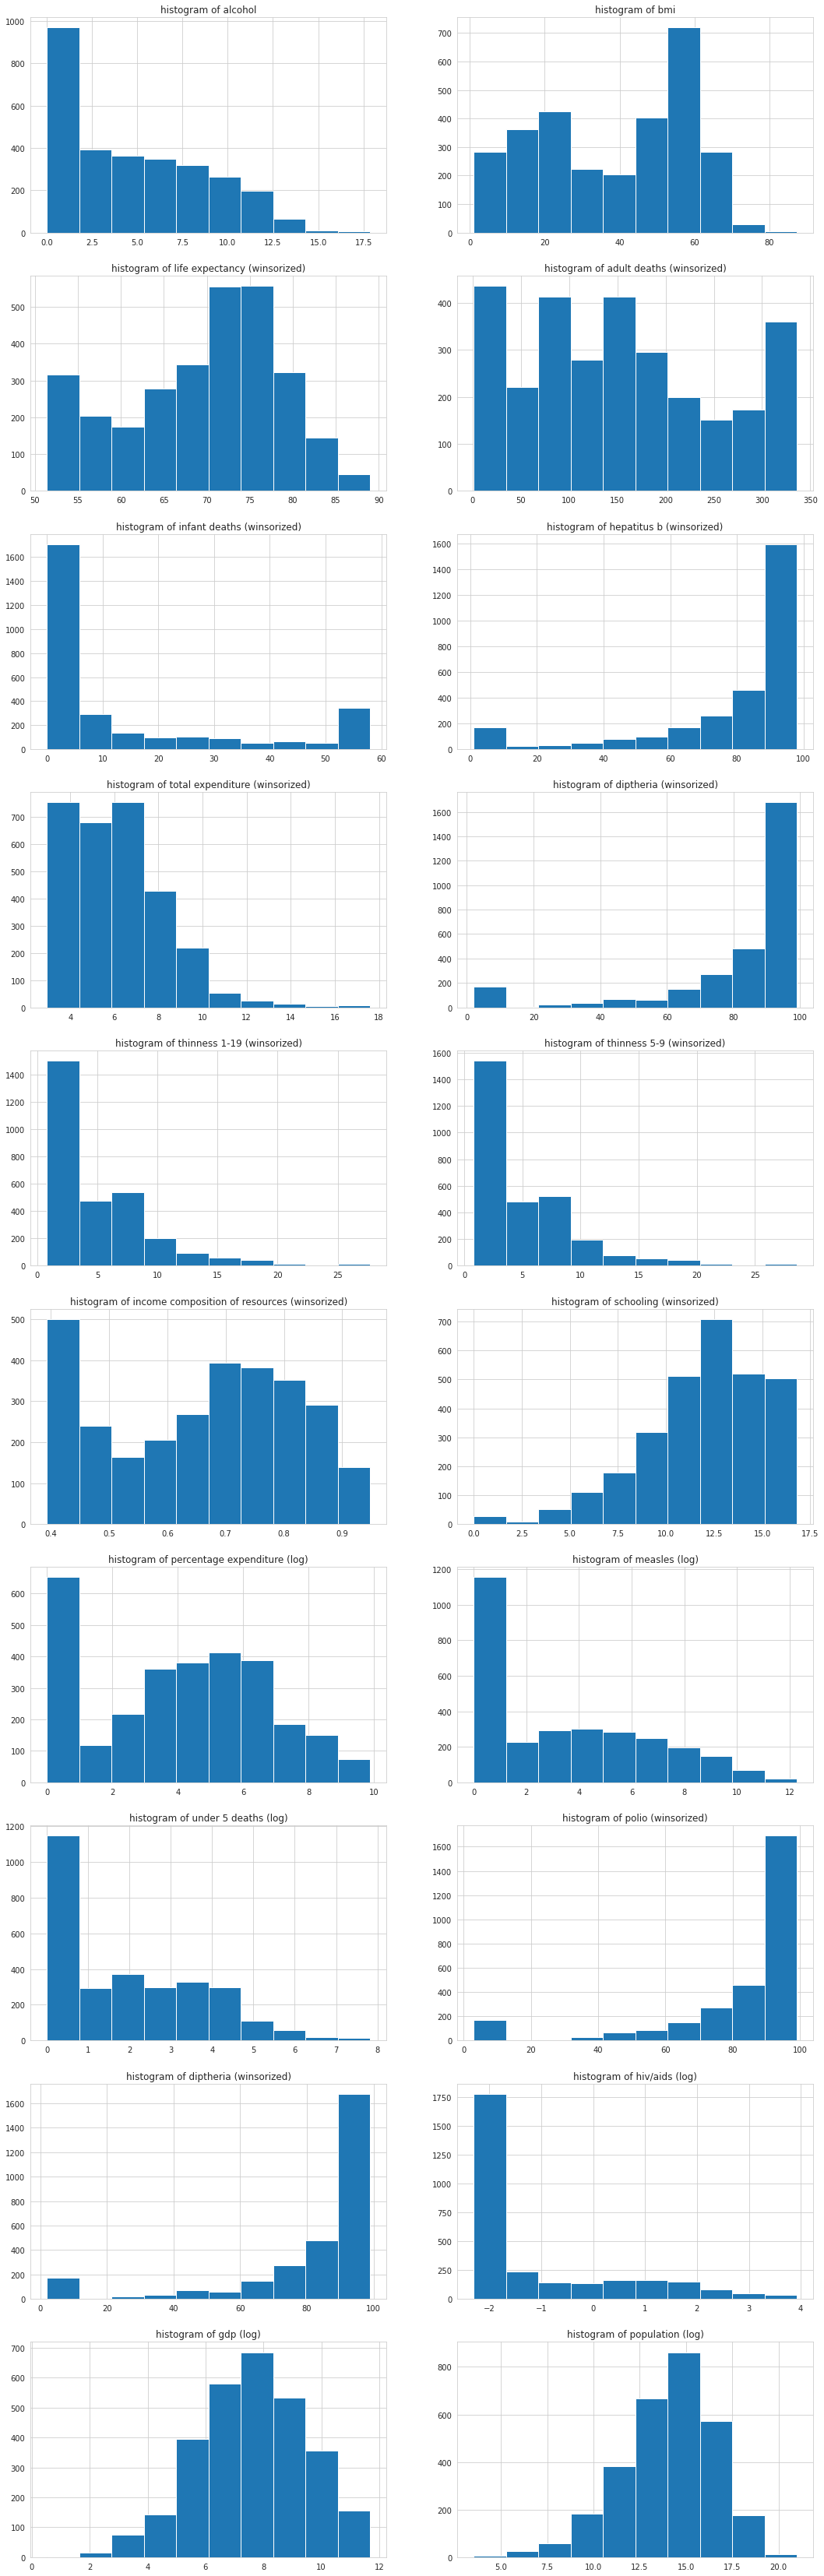

In [30]:
#let's look at histograms for non-winsorized, winsorized, and logarithm variables to estimate the distribution

#(you could also create a new column if you wanted for ***
#winsorized variables lifeexpect_df[' winsorized_popultion'] = winsorized_population. )

#non-winsorized

plt.figure(figsize=(18,60))

plt.subplot(10, 2, 1)
plt.hist(lifeexpect_df['Alcohol'])
plt.title("histogram of alcohol")

plt.subplot(10, 2, 2)
plt.hist(lifeexpect_df[' BMI '])
plt.title("histogram of bmi")

#winsorized

plt.subplot(10, 2, 3)
plt.hist(lifeexpect_df['winsorized_expectancy'])
plt.title("histogram of life expectancy (winsorized)")

plt.subplot(10, 2, 4)
plt.hist(lifeexpect_df['winsorized_adult'])
plt.title("histogram of adult deaths (winsorized)")

plt.subplot(10, 2, 5)
plt.hist(lifeexpect_df['winsorized_infant'])
plt.title("histogram of infant deaths (winsorized)")

plt.subplot(10, 2, 6)
plt.hist(lifeexpect_df['winsorized_hepatitis'])
plt.title("histogram of hepatitus b (winsorized)")

plt.subplot(10, 2, 7)
plt.hist(lifeexpect_df['winsorized_totalexp'])
plt.title("histogram of total expenditure (winsorized)")

plt.subplot(10, 2, 8)
plt.hist(lifeexpect_df['winsorized_diptheria'])
plt.title("histogram of diptheria (winsorized)")

plt.subplot(10, 2, 9)
plt.hist(lifeexpect_df['winsorized_thin119'])
plt.title("histogram of thinness 1-19 (winsorized)")

plt.subplot(10, 2, 10)
plt.hist(lifeexpect_df['winsorized_thin59'])
plt.title("histogram of thinness 5-9 (winsorized)")

plt.subplot(10, 2, 11)
plt.hist(lifeexpect_df['winsorized_incomecomp'])
plt.title("histogram of income composition of resources (winsorized)")

plt.subplot(10, 2, 12)
plt.hist(lifeexpect_df['winsorized_schooling'])
plt.title("histogram of schooling (winsorized)")

plt.subplot(10, 2, 16)
plt.hist(lifeexpect_df['winsorized_polio'])
plt.title("histogram of polio (winsorized)")

plt.subplot(10, 2, 17)
plt.hist(lifeexpect_df['winsorized_diptheria'])
plt.title("histogram of diptheria (winsorized)")

#log transformed variables
#in this situation we have a value of 0 and this is why the histogram is not running and giving -int error, to fix add 1

plt.subplot(10, 2, 13)
plt.hist(np.log(lifeexpect_df["percentage expenditure"]+1))
plt.title("histogram of percentage expenditure (log)")

plt.subplot(10, 2, 14)
plt.hist(np.log(lifeexpect_df["Measles "]+1))
plt.title("histogram of measles (log)")

plt.subplot(10, 2, 15)
plt.hist(np.log(lifeexpect_df["under-five deaths "]+1))
plt.title("histogram of under 5 deaths (log)")

#first number in subplot is the number of rows should stay the same, the second is then number of columns, and the third is which
#grid you want to draw the graph on***

plt.subplot(10, 2, 18)
plt.hist(lifeexpect_df["log_HIV/AIDS"]) 
plt.title("histogram of hiv/aids (log)")

plt.subplot(10, 2, 19)
plt.hist(lifeexpect_df["log_GDP"])
plt.title("histogram of gdp (log)")

plt.subplot(10, 2, 20)
plt.hist(lifeexpect_df["log_Population"])
plt.title("histogram of population (log)")

plt.show()

In [0]:
#as we can see the variables plotted above are mostly skewed in a dramatic fashion, now let's explore the data with bivariate/
#multivariate analysis comparing continuous variables against life expectancy as our target

#change titles of your histograms

In [32]:
lifeexpect_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,winsorized_expectancy,winsorized_adult,winsorized_infant,winsorized_hepatitis,winsorized_polio,winsorized_totalexp,winsorized_diptheria,winsorized_thin119,winsorized_thin59,winsorized_incomecomp,winsorized_schooling,log_percentage_expenditure,log_measles,log_under-five_deaths,log_HIV/AIDS,log_Population,log_GDP
Year,1.000000,0.169668,-0.078310,-0.037415,-0.003692,0.031400,0.135460,-0.082493,0.110833,-0.042937,0.093690,0.083912,0.133571,-0.139741,0.113524,0.018383,-0.050206,-0.053773,0.236837,0.211163,0.160214,-0.051525,-0.048067,0.135081,0.093690,0.090679,0.133571,-0.050025,-0.053585,0.186610,0.212717,0.159427,-0.136869,-0.046995,-0.095239,0.042430,0.174320
Life expectancy,0.169668,1.000000,-0.696291,-0.196533,0.381467,0.381799,0.211554,-0.157573,0.555353,-0.222500,0.462809,0.196527,0.476136,-0.556433,0.415859,-0.014692,-0.475357,-0.471464,0.694386,0.713798,0.995171,-0.657988,-0.561501,0.210810,0.462809,0.217580,0.476136,-0.474097,-0.469080,0.807068,0.713759,0.596804,-0.315395,-0.554894,-0.812736,-0.070391,0.531931
Adult Mortality,-0.078310,-0.696291,1.000000,0.078604,-0.183271,-0.243027,-0.133621,0.031070,-0.376455,0.093984,-0.274295,-0.101616,-0.273851,0.523382,-0.273152,-0.021107,0.301313,0.308173,-0.445300,-0.438535,-0.690151,0.954153,0.361074,-0.133023,-0.274295,-0.115075,-0.273851,0.299957,0.306136,-0.530979,-0.438215,-0.356289,0.164841,0.318531,0.642447,0.067284,-0.333344
infant deaths,-0.037415,-0.196533,0.078604,1.000000,-0.112583,-0.085612,-0.162605,0.501128,-0.227297,0.996629,-0.170762,-0.125638,-0.175167,0.025231,-0.092197,0.538959,0.465649,0.471133,-0.134082,-0.179893,-0.201062,0.087906,0.476575,-0.162496,-0.170762,-0.137841,-0.175167,0.467045,0.472857,-0.172330,-0.181886,-0.188297,0.374950,0.531514,0.107250,0.209565,-0.146377
Alcohol,-0.003692,0.381467,-0.183271,-0.112583,1.000000,0.321600,0.069259,-0.052594,0.324307,-0.109757,0.203725,0.290209,0.210794,-0.050643,0.308460,-0.042276,-0.411191,-0.399086,0.419153,0.484275,0.393117,-0.204911,-0.310174,0.069409,0.203725,0.314670,0.210794,-0.412267,-0.398784,0.503815,0.480911,0.449976,-0.212921,-0.327144,-0.179797,-0.005313,0.389202
percentage expenditure,0.031400,0.381799,-0.243027,-0.085612,0.321600,1.000000,-0.022773,-0.056596,0.227428,-0.087852,0.147025,0.170252,0.143270,-0.097857,0.814353,-0.021809,-0.251955,-0.253782,0.359323,0.372238,0.392292,-0.267852,-0.220311,-0.022220,0.147025,0.201385,0.143270,-0.248724,-0.249444,0.423527,0.354219,0.643275,-0.121895,-0.285316,-0.209660,0.001144,0.513783
Hepatitis B,0.135460,0.211554,-0.133621,-0.162605,0.069259,-0.022773,1.000000,-0.077641,0.138004,-0.167670,0.398281,0.045909,0.475389,-0.136069,0.044324,-0.087433,-0.114939,-0.119593,0.154966,0.162368,0.211465,-0.120926,-0.207495,0.999941,0.398281,0.042862,0.475389,-0.117762,-0.122601,0.193671,0.170722,0.093689,-0.198995,-0.235916,-0.204690,-0.036141,0.119106
Measles,-0.082493,-0.157573,0.031070,0.501128,-0.052594,-0.056596,-0.077641,1.000000,-0.176418,0.507809,-0.136114,-0.104272,-0.141878,0.030899,-0.021545,0.230051,0.224270,0.220304,-0.090381,-0.096524,-0.155053,0.030527,0.353292,-0.077498,-0.136114,-0.113731,-0.141878,0.224490,0.220529,-0.087168,-0.097199,-0.137980,0.486539,0.366566,0.102066,0.088692,-0.069140
BMI,0.110833,0.555353,-0.376455,-0.227297,0.324307,0.227428,0.138004,-0.176418,1.000000,-0.237649,0.280785,0.231194,0.280725,-0.241562,0.246536,-0.058720,-0.531100,-0.537421,0.465075,0.494304,0.562114,-0.387983,-0.447772,0.137566,0.280785,0.250076,0.280725,-0.526897,-0.532871,0.549275,0.495869,0.443166,-0.331097,-0.475774,-0.477656,-0.040430,0.383808
under-five deaths,-0.042937,-0.222500,0.093984,0.996629,-0.109757,-0.087852,-0.167670,0.507809,-0.237649,1.000000,-0.188800,-0.127004,-0.195643,0.038062,-0.0

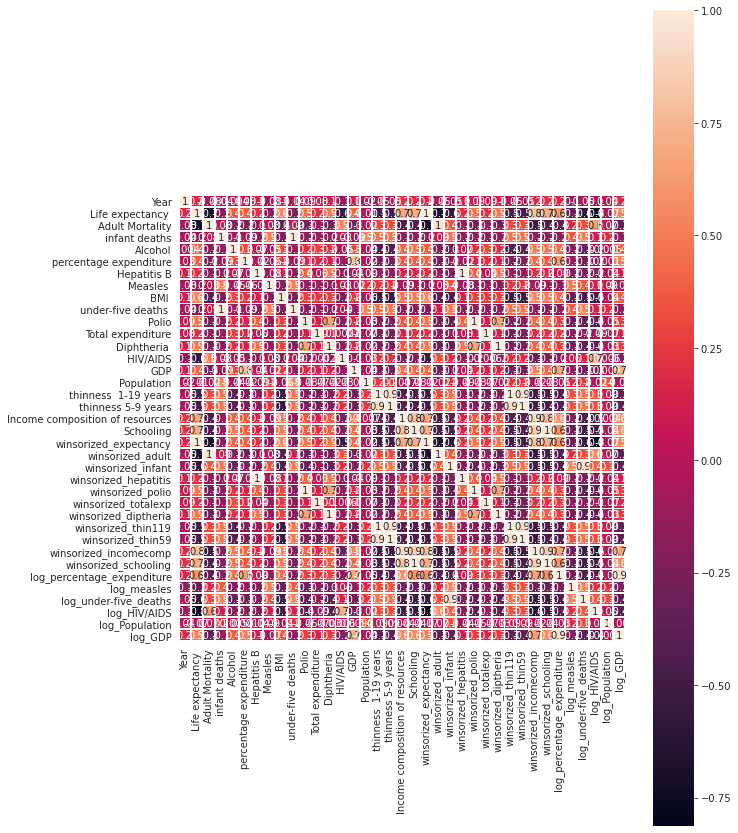

In [33]:
#create a heat map from the correlation

plt.subplots(figsize=(10,15)) 

sns.heatmap(lifeexpect_df.corr(), annot = True, linewidths=.8, square=True, fmt='.1g')

Life Expectancy has the strongest positive correlations with: schooling, and income composition of resources

Life Expectancy has the strongest negative correlations with: HIV/AIDS and Adult Mortality

let's test this correlation again to be sure with scatter plots

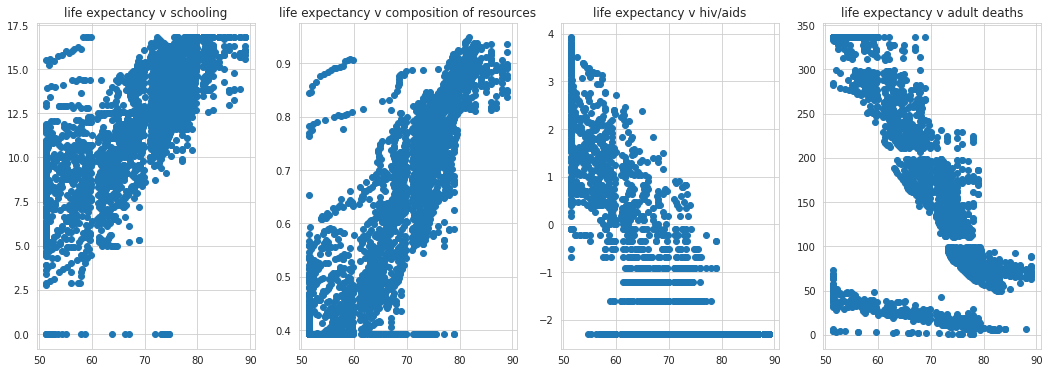

In [34]:
plt.figure(figsize=(18,6))

plt.subplot(1,4,1) #two rows with two columns and 1 plot (2,2,1) rows-columns-plot
plt.scatter(lifeexpect_df['winsorized_expectancy'], lifeexpect_df['winsorized_schooling'])
plt.title("life expectancy v schooling")

plt.subplot(1,4,2)
plt.scatter(lifeexpect_df['winsorized_expectancy'], lifeexpect_df['winsorized_incomecomp'])
plt.title("life expectancy v composition of resources")

plt.subplot(1,4,3)
plt.scatter(lifeexpect_df['winsorized_expectancy'], lifeexpect_df["log_HIV/AIDS"])
plt.title("life expectancy v hiv/aids")

plt.subplot(1,4,4)
plt.scatter(lifeexpect_df['winsorized_expectancy'], lifeexpect_df['winsorized_adult'])
plt.title("life expectancy v adult deaths")

plt.show()

In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.



ANSWER: we can see the relationship between life expectancy and adult deaths is too weak so I will look at hiv/aids instead
we now see with hiv/aids the relationship is strong but inversely therefore I will use hiv/aids, income comp of resources, and
schooling as my features to measure against my target variable being life expectancy

A few notes: gdp and percentage expenditure have a very strong relationship so I will toss them out. As well as infant and under five deaths, both thinness variables. 



Summary

In conclusion, after cleaning up the dataset and minimizing the impact of major outliers within many of the variables, I can see that as schooling and income composition of resources increases so does life expectancy. And as the rate of HIV/AIDS decreases so does life expectancy. These were the variables with the strongest relationship to life expectancy in the data set. 